In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [88]:
# ============= Import required packaages ==============

from typing import Tuple
from itertools import compress,product

import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import pickle

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
# from ...custom_classes_defs.preprocessing import *
# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
# from custom_classes_defs.unet import *  
from custom_classes_defs.fnet0 import *
# from custom_classes_defs.fnet_like import *
# from custom_classes_defs.fnet import *


RND_STATE = 247
BATCH_SIZE = 512
EPOCHS = 100
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

In [89]:
time_start= time.time()

seis_path = "./data/reconstruction/thebe/thebe_data"
label_path = "./data/reconstruction/thebe/thebe_data"
save_path = "./models/Thebe/fnet00"

thebe = Thebe(seis_path,label_path)

## Alternatively: use ratio to select a smaller fraction of data:
# thebe = Thebe(seis_path,label_path, ratio=0.1)

# Create datasets for respective data samples and labels
# x_test, y_test = thebe.data_generator(sub_group='test',as_numpy=True)
x_test, y_test = np.load(join(seis_path, 'seis_test.npy')),\
      np.load(join(label_path, 'fault_test.npy'))

thebe.test_size = x_test.shape[0]
thebe.img_size = x_test.shape[1:]
        
print("Size of test data: {}".format(thebe.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-time_start) / 60))

Size of test data: 2312
...elapsed time: ___ 0.00 minutes___


In [90]:
# Model configurations
conf = model_config(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path=save_path,   ## path to saved model data
    img_shape=thebe.img_size,
    target_size=thebe.img_size,
    threshold=thebe.threshold,
    pos_label=thebe.pos_label
)

assert not(conf.new_training_session)

conf.info()

             NUM_GPU: 0
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: None
new_training_session: False
           pos_label: 1
resume_training_session: 0
           save_path: ./models/Thebe/fnet00
           test_size: None
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle: True
                       verbose: 0
   training_duration: None
     validation_size: None


## Build and load model weights

In [91]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build models', '-'*55))

# m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch, add_residual=False)
model = m_obj.build_model()
model.load_weights(glob(conf.save_path+'/*.h5')[0])  ## I.e. model.load_weights("path-to-weights")



	Build models
-------------------------------------------------------


## Make prediction on sample test data

In [92]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
start = time.time()
y_pred = model.predict(x_test, batch_size=BATCH_SIZE)

start = time.time() - start
print("evaluation elapsed time:___{:5.2f}___minutes" \
                .format(start/60))




	Evaluate fnet model
-------------------------------------------------------
5/5 [==============================] - 177s 35s/step
evaluation elapsed time:___ 2.95___minutes


In [93]:
# for thebe test dataset

im_height = 1537
im_width = 3174

In [94]:
horizontal_splits_number = 67
print(horizontal_splits_number)
width_after_pad = 3312
print(width_after_pad)
left_pad = 69 
right_pad = 69
print(left_pad,right_pad)

vertical_splits_number = 33
print(vertical_splits_number)
height_after_pad = 1680
print(height_after_pad)
top_pad = 71 
bottom_pad = 72 
print(top_pad,bottom_pad)

67
3312
69 69
33
1680
71 72


In [95]:
horizontal_splits_number = horizontal_splits_number+1
print(horizontal_splits_number)
vertical_splits_number = vertical_splits_number+1
print(vertical_splits_number)

68
34


In [96]:
halfoverlapsize = 24
print(halfoverlapsize)

24


In [97]:
def recover_Image(patches: np.ndarray, imsize: Tuple[int, int, int], left_pad,right_pad,top_pad,bottom_pad, overlapsize):
#     patches = np.squeeze(patches)
    assert len(patches.shape) == 5

    i_h, i_w, i_chan = imsize
    image = np.zeros((i_h+top_pad+bottom_pad, i_w+left_pad+right_pad, i_chan), dtype=patches.dtype)
    divisor = np.zeros((i_h+top_pad+bottom_pad, i_w+left_pad+right_pad, i_chan), dtype=patches.dtype)
#     print("i_h, i_w, i_chan",i_h, i_w, i_chan)
    n_h, n_w, p_h, p_w,_= patches.shape
    
    o_w = overlapsize
    o_h = overlapsize

    s_w = p_w - o_w
    s_h = p_h - o_h

    for i, j in product(range(n_h), range(n_w)):
        patch = patches[i,j]
        image[(i * s_h):(i * s_h) + p_h, (j * s_w):(j * s_w) + p_w] += patch
        divisor[(i * s_h):(i * s_h) + p_h, (j * s_w):(j * s_w) + p_w] += 1

    recover = image / divisor
    return recover[top_pad:top_pad+i_h, left_pad:left_pad+i_w]

In [98]:
test_predictions = y_pred

tosave = tf.stack(test_predictions).numpy()[:vertical_splits_number * horizontal_splits_number]
test_predictions = test_predictions[vertical_splits_number * horizontal_splits_number:]
print(tosave.shape)
tosave = np.reshape(tosave, (vertical_splits_number, horizontal_splits_number, 96, 96, 1))
print(tosave.shape)

recover_Y_test_pred = recover_Image(tosave, (1537, 3174, 1), left_pad, right_pad, top_pad, bottom_pad, 48)
print(recover_Y_test_pred.shape)
squeezed_ypred = np.squeeze(recover_Y_test_pred, axis=-1) 
print(squeezed_ypred.shape)

(2312, 96, 96, 1)
(34, 68, 96, 96, 1)
(1537, 3174, 1)
(1537, 3174)


In [99]:
cmap='seismic'

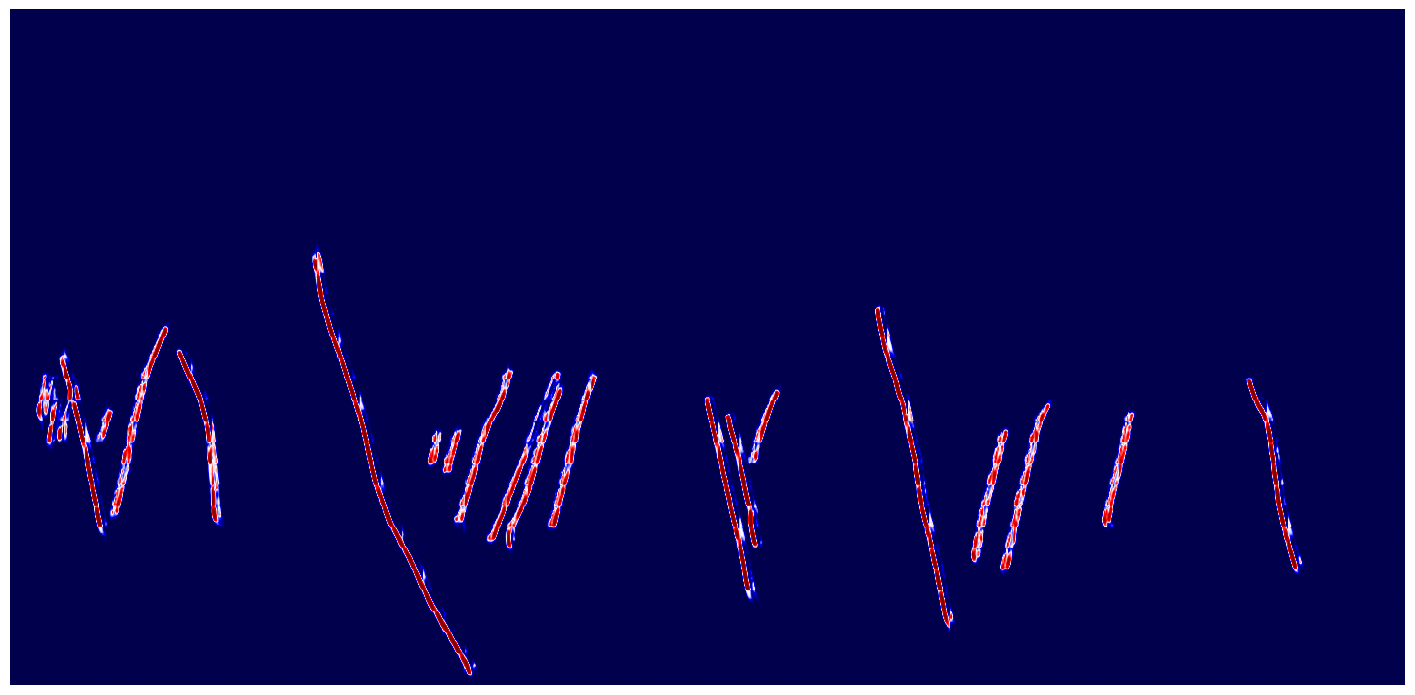

In [100]:
plt.figure(figsize=(18,18))
plt.imshow(squeezed_ypred,cmap=cmap)
plt.axis('off')
plt.show()

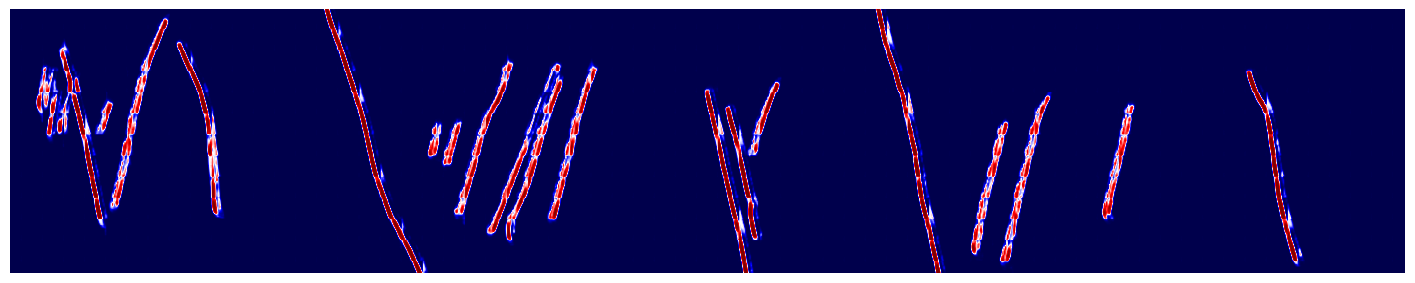

In [101]:
plt.figure(figsize=(18,18))
plt.imshow(squeezed_ypred[700:1300,:],cmap=cmap)
plt.axis('off')
plt.show()